<a href="https://colab.research.google.com/github/kaitken17/colab_stuff/blob/master/sythetic_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import functools

import jax
import jax.numpy as jnp
from jax.experimental import optimizers
from jax.experimental import stax

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

from tqdm.notebook import tqdm

import os
import time
import pickle

from sklearn.decomposition import PCA

import sys
sys.path.append('/content/drive/My Drive/ml_research/fixedpoints_nlp/reverse-engineering-neural-networks')

import renn

In [2]:
# Skips any tests and just runs function definitions
run_tests = True

# Synthetic Data

#### Function Defs

In [3]:
def generateWordBank(toy_params):
  """
  Creates the word bank based on various inputs
  """

  context_words = toy_params['context_words']
  variable_length = toy_params['variable_length']
  unordered = toy_params['unordered_class']
  if unordered:
    words = []
    n_unordered = toy_params['n_unordered']
    for i in range(n_unordered):
      words.extend(['kinda'+str(i), 'very'+str(i)])
  else:
    words = ['awful', 'bad', 'good', 'awesome']
  
  # words.extend(['the', 'the2', 'the3', 'the4', 'the5'])
  words.extend(['the'])

  if context_words:
    words.extend(['not', 'extremely'])
  if variable_length:
    words.append('<EoS>')

  return words

def make_toy_phrase(toy_params):
  """
  Creates a single toy phrase
  """
  
  phrase_length = toy_params['phrase_length']
  words = toy_params['words']
  variable_length = toy_params['variable_length']
  min_phrase_len = toy_params['min_phrase_len']

  phrase = []
  n_words = len(words)
  # Sets phrase length, allowing for variable length
  if variable_length:
    length = min_phrase_len + np.random.randint(phrase_length - min_phrase_len)
  else:
    length = phrase_length
  
  for idx in range(length):
    next_word = False
    while not next_word:
      next_word = False
      # Create the white noise input.
      word_idx = np.random.randint(n_words)
      if words[word_idx] == 'extremely' and idx > 0: # No repeat 'extremely'
        if phrase[idx-1] != 'extremely':
          next_word = True
      elif words[word_idx] == 'not' and idx > 0: # No repeat 'not'
        found_not = False
        for idx2 in range(1, min(4, idx+1)): # up to 4 words back
          if phrase[idx-idx2]== 'not':
            found_not = True
        if not found_not:
          next_word = True
      elif words[word_idx] != '<EoS>':
        next_word = True
    phrase.append(words[word_idx])

  # Adds EoS at end for variable length phrases
  if variable_length:
    phrase.append('<EoS>')
  
  return phrase

def eval_toy_phrase(toy_phrase, toy_params):
  """
  Evaluates a single toy phrase and returns a score
  """
  max_phrase_length = toy_params['phrase_length']
  unordered = toy_params['unordered_class']

  if unordered:
    n_unordered = toy_params['n_unordered']
    score = np.zeros((n_unordered,))
    base_word_vals = {}
    for i in range(n_unordered):
      base_word_vals['kinda'+str(i)] = np.zeros((n_unordered,))
      base_word_vals['kinda'+str(i)][i] = 1
      base_word_vals['very'+str(i)] = np.zeros((n_unordered,))
      base_word_vals['very'+str(i)][i] = 2
    # base_word_vals['kinda01'] = np.zeros((n_unordered,))
    # base_word_vals['kinda01'][0] = 1/2
    # base_word_vals['kinda01'][1] = 1/2
    # base_word_vals['bad0'] = np.zeros((n_unordered,))
    # base_word_vals['bad0'][0] = -1
    # base_word_vals['bad1'] = np.zeros((n_unordered,))
    # base_word_vals['bad1'][1] = -1
    base_word_vals['kinda1100'] = np.asarray([1,1,0,0])
    base_word_vals['kinda0011'] = np.asarray([0,0,1,1])
    base_word_vals['kinda1010'] = np.asarray([1,0,1,0])
    base_word_vals['kinda0101'] = np.asarray([0,1,0,1])
    # base_word_vals['kinda0'] = np.asarray([1, 1/3])
    # base_word_vals['kinda1'] = np.asarray([0, 2/3])
  else:
    score = 0
    base_word_vals = {'awful': -2, 'bad': -1, 'the': 0, 'good': 1, 'awesome': 2}
  phrase_length = len(toy_phrase)
  extreme_length = 0 # range of influence of extreme
  not_length = 0 # range of influence of not

  for idx in range(phrase_length):
    if toy_phrase[idx] in list(base_word_vals.keys()):
      base_score = base_word_vals[toy_phrase[idx]]
      if not_length > 0: 
        base_score = -1 * base_score
      if extreme_length > 0: 
        base_score = 2 * base_score
      score += base_score
    elif toy_phrase[idx] == 'not':
      not_length = 4
    elif toy_phrase[idx] == 'extremely':
      extreme_length = 2
    elif toy_phrase[idx] == '<EoS>': break
    
    if not_length > 0: not_length -= 1 # decays not
    if extreme_length > 0: extreme_length -= 1 # decays extremely
  
  # Normalizes by approximate variance
  score /= np.sqrt(2 * max_phrase_length)

  return score

def wordToIndex(word, word_bank):
  """
  Converts a word into corresponding index in words
  """
  return word_bank.index(word)

def wordToTensor(word, word_bank):
  """ Turn a letter into a <1 x n_words> Tensor """
  n_words = len(word_bank)
  tensor = np.zeros((1, n_words))
  tensor[0][wordToIndex(word, word_bank)] = 1
  return np.array(tensor)

def phraseToTensor(phrase, word_bank):
  """
  Turn a phrase into a <phrase_length x n_words> (an array of one-hot letter vectors)
  """
  n_words = len(word_bank)
  tensor = np.zeros((len(phrase), n_words))
  for wi, word in enumerate(phrase):
      tensor[wi][wordToIndex(word, word_bank)] = 1
  return np.array(tensor)

def classifySentiment(score, toy_params):
  """
  Turns a score of a toy phrase into a sentiment and corresponding tensor
  Contains definitions of thresholds for dividing into multiple classes
  """
  sentiments = toy_params['sentiments']
  unordered = toy_params['unordered_class']
  loss_type = toy_params['loss_type']
  phrase_length = toy_params['phrase_length']

  n_sentiments = len(sentiments)

  if unordered:
    sentiment = 'sent'+str(np.argmax(score))
    sentiment_tensor_final = np.zeros((n_sentiments,))
    sentiment_tensor_final[np.argmax(score)] = 1.0
    sentiment_tensor = np.array([np.zeros((n_sentiments,)) if idx != phrase_length-1 else sentiment_tensor_final for idx in range(phrase_length)])
  else:
    # Used for 3-class sentiment analysis, about 1/3 will be neutral
    neutral_thresh = 0.43

    # 5-class sentiment analysis, about 1/5 will be of each class
    three_star_thresh = 0.253
    four_star_thresh = 0.843

    if loss_type == 'XE':
      if n_sentiments == 2:
        if score >= 0:
          sentiment = 'Good'
        else:
          sentiment = 'Bad'
      elif n_sentiments == 3:
        if score >= neutral_thresh:
          sentiment = 'Good'
        elif score <= -1 * neutral_thresh:
          sentiment = 'Bad'
        else:
          sentiment = 'Neutral'
      elif n_sentiments == 5:
        if score > four_star_thresh:
          sentiment = 'Five'
        elif score > three_star_thresh:
          sentiment = 'Four'
        elif score > -1 * three_star_thresh:
          sentiment = 'Three'
        elif score > -1 * four_star_thresh:
          sentiment = 'Two'
        else:
          sentiment = 'One'
      sentiment_tensor_final = np.zeros((n_sentiments,))
      sentiment_tensor_final[sentiments.index(sentiment)] = 1.0
      sentiment_tensor = np.array([np.zeros((n_sentiments,)) if idx != phrase_length-1 else sentiment_tensor_final for idx in range(phrase_length)])
    elif loss_type == 'MSE':
        sentiment = score
        sentiment_tensor = np.array([[0.0] if idx != phrase_length-1 else [score] for idx in range(phrase_length)])
  
  return sentiment, sentiment_tensor

def randomTrainingExample(toy_params):
  """
  Generates a random training example consisting of phrase and sentiment and corresponding tensors

  Returns:
  sentiment_tensor: time x input dim (word bank size)
  sentiment_tensor: 1 x output dim (sentiment bank size)

  """
  # Unpacks toy_params (with defaults)
  phrase_length = toy_params['phrase_length']
  words = toy_params['words']
  sentiments = toy_params['sentiments']
  loss_type = toy_params['loss_type'] if 'loss_type' in toy_params else 'XE'
  variable_length = toy_params['variable_length'] if 'variable_length' in toy_params else 'False'
  min_phrase_len = toy_params['min_phrase_len'] if 'min_phrase_len' in toy_params else 10
  unordered_class = toy_params['unordered_class'] if 'unordered_class' in toy_params else 'False'

  phrase = make_toy_phrase(toy_params)
  score = eval_toy_phrase(phrase, toy_params)
  
  sentiment, sentiment_tensor = classifySentiment(score, toy_params)
  targets_t = np.zeros(phrase_length-1)

  phrase_tensor = phraseToTensor(phrase, words)
  target_mask = np.array([len(phrase)-1], dtype=int) # When target is defined.
  
  return sentiment, phrase, sentiment_tensor, phrase_tensor, target_mask

def default_params(toy_params):
  """ Sets the defaults of many parameters if not specified"""
  if 'variable_length' not in toy_params: toy_params['variable_length'] = False
  if 'unordered_class' not in toy_params: toy_params['unordered_class'] = False
  if 'min_phrase_len' not in toy_params: toy_params['min_phrase_len'] = 10

  return toy_params

#### Toy Data Tests

In [4]:
# Various tests/confirmations of phrase generation
if run_tests:
  
  toy_params = {
    'phrase_length': 50,
    'loss_type': 'XE',
    'context_words' : False,
    'variable_length': False, # Takes max phrase length as phrase length
    'min_phrase_len': 10,
    'unordered_class': True, # Use an unordered class set (red, green, blue)
    'n_unordered': 7
  }

  toy_params['words'] = generateWordBank(toy_params)
  # toy_params['sentiments'] = ['One', 'Two', 'Three', 'Four', 'Five']
  # toy_params['sentiments'] = ['Red', 'Green', 'Blue']
  toy_params['sentiments'] = ['Bad', 'Good']
  if toy_params['unordered_class']:
    toy_params['sentiments'] = ['sent'+str(i) for i in range(toy_params['n_unordered'])]

  # Makes five phrases and reports scores
  print('Five phrases and scores:')
  for i in range(5):
    toy_phrase = make_toy_phrase(toy_params)
    print(toy_phrase)
    score = eval_toy_phrase(toy_phrase, toy_params)
    print(score)

  # Test Tensor conversion of toy phrases
  sentiment, phrase, sentiment_tensor, phrase_tensor, target_mask = randomTrainingExample(toy_params)
  print('Toy phrase:', phrase[:12])
  print('Toy phrase score:', eval_toy_phrase(phrase, toy_params))
  print('Tensor for phrase:', phrase_tensor[:12])
  print('Target mask:', target_mask)
  print('Shape of phrase tensor', phrase_tensor.shape)
  # print('Sentiment tensor', sentiment_tensor)
  print('Shape of sentiment tensor', sentiment_tensor.shape)

  # Random generation of training examples
  for i in range(4):
    sentiment, phrase, sentiment_tensor, phrase_tensor, _ = randomTrainingExample(toy_params)
    print('sentiment =', sentiment, '/ phrase =', phrase)

  # Makes many phrases and evaluates scores to see distribution
  if not toy_params['unordered_class']:
    trials = 10000
    scores = []
    lengths = []
    for trial in range(trials):
      toy_phrase = make_toy_phrase(toy_params)
      lengths.append(len(toy_phrase))
      score = eval_toy_phrase(toy_phrase, toy_params)
      scores.append(score)

    if not toy_params['unordered_class']:
      print('Variance:', np.var(scores))

      # Histogram of scores
      plt.hist(scores, bins=40)
      plt.show()

    if toy_params['variable_length']:
      # Histogram of lengths
      plt.hist(lengths, bins=len(set(lengths)))
      plt.show()

Five phrases and scores:
['very2', 'very4', 'kinda3', 'very5', 'kinda1', 'the', 'the', 'kinda1', 'very6', 'kinda4', 'kinda4', 'kinda0', 'very1', 'very2', 'kinda6', 'kinda3', 'very5', 'kinda6', 'very1', 'very1', 'kinda5', 'the', 'very2', 'kinda3', 'very0', 'kinda0', 'very5', 'very4', 'kinda2', 'the', 'kinda1', 'the', 'kinda6', 'very6', 'kinda3', 'kinda5', 'very3', 'very3', 'very5', 'kinda2', 'very4', 'very0', 'kinda3', 'kinda5', 'very2', 'kinda3', 'kinda4', 'very5', 'kinda3', 'very0']
[0.8 0.9 1.  1.1 0.9 1.3 0.7]
['very5', 'very6', 'kinda5', 'kinda5', 'kinda5', 'kinda2', 'very2', 'very4', 'kinda6', 'very4', 'kinda6', 'very4', 'very4', 'very1', 'kinda3', 'very0', 'very1', 'kinda3', 'kinda0', 'very3', 'kinda4', 'the', 'kinda4', 'kinda5', 'very4', 'kinda4', 'very0', 'very4', 'kinda3', 'very4', 'very6', 'very0', 'kinda4', 'very3', 'kinda2', 'very6', 'kinda3', 'very3', 'kinda4', 'the', 'kinda0', 'kinda1', 'kinda4', 'kinda6', 'very2', 'kinda3', 'kinda1', 'kinda1', 'kinda0', 'kinda3']
[0.9 0.

In [5]:
if run_tests:
  toy_params = {
    'phrase_length': 50,
    'loss_type': 'XE',
    'context_words' : False,
    'variable_length': False, # Takes max phrase length as phrase length
    'min_phrase_len': 10,
    'unordered_class': True, # Use an unordered class set
    'n_unordered': 2,
  }

  toy_params['words'] = ['kinda0', 'kinda2', 'the'] #generateWordBank(toy_params)
  # toy_params['words'].append('kinda01')
  # toy_params['words'].append('kinda01')
  # toy_params['words'].remove('kinda0')
  # toy_params['words'].remove('kinda1')
  # toy_params['sentiments'] = ['Bad', 'Neutral', 'Good']
  if toy_params['unordered_class']:
    toy_params['sentiments'] = ['sent'+str(i) for i in range(toy_params['n_unordered'])]

  # Makes many phrases and evaluates scores to see distribution
  trials = 10000
  scores = np.zeros((trials, toy_params['n_unordered']))
  for trial in range(trials):
    toy_phrase = make_toy_phrase(toy_params)
    score = eval_toy_phrase(toy_phrase, toy_params)
    scores[trial] = score

In [6]:
if run_tests:
  scores_adj =  np.zeros((trials, toy_params['n_unordered']))

  for i in range(toy_params['n_unordered']):
    print('Mean:'.format(i), np.mean(scores[:,i]))
    scores_adj[:,i] = scores[:,i] - np.mean(scores[:,i])

  print(np.cov(scores_adj.T))

Mean: 1.6651100000000003
Mean: 0.0
[[0.11080077 0.        ]
 [0.         0.        ]]


# Train and Build Network

#### Training Functions

In [7]:
def build_rnn(rnn_specs):
  """Builds a single layer RNN (GRU/LSTM with readout)"""

  vocab_size = rnn_specs['input_size']
  num_units = rnn_specs['hidden_size']
  num_outputs = rnn_specs['output_size']

  # Build the RNN cell.
  if rnn_specs['cell_type'] == 'GRU':
    cell = renn.rnn.cells.GRU(num_units)
  elif rnn_specs['cell_type'] == 'LSTM':
    cell = renn.rnn.cells.LSTM(num_units)
  if rnn_specs['ro_bias']:
    readout_init, readout_apply = stax.Dense(num_outputs)
  else:
    readout_init, readout_apply = Dense_nobias(num_outputs)

  def init_fun(prng_key, input_shape):
    """Initializes the network (the embedding and the RNN cell)."""
    k0, k1 = jax.random.split(prng_key, 2)
    output_shape, rnn_params = cell.init(k0, input_shape[1:])
    _, readout_params = readout_init(k1, output_shape)

    # We explicitly add the batch dimension back in.
    # (This is because we only applied `vmap` to the rnn_apply function above)
    batch_output_shape = (input_shape[0],) + output_shape

    return batch_output_shape, (rnn_params, readout_params)

  def apply_fun(params, inputs):
    """Applies the RNN."""
    # Destructure parameter tuple.
    rnn_params, readout_params = params

    # [batch, len, dim]
    initial_states = cell.get_initial_state(
        rnn_params, batch_size=inputs.shape[0])

    batch_apply = functools.partial(cell.batch_apply, rnn_params)
    all_logits = renn.rnn.unroll.unroll_rnn(
        initial_states, inputs, batch_apply,
        functools.partial(readout_apply, readout_params))

    return all_logits

  def mask_fun(sequences, last_index):
    """Selects the last valid timestep from a batch of padded sequences."""
    last_index = last_index[:, jnp.newaxis, jnp.newaxis]
    return jnp.take_along_axis(sequences, last_index, axis=1)

  def sigmoid_xent_with_logits(logits, labels):
    return jnp.maximum(logits, 0) - logits * labels + \
        jnp.log(1 + jnp.exp(-jnp.abs(logits)))

  def xe_loss_fn(logits, labels):
    """
    Contains both log softmax and negative log liklihood loss
    """
    # Shifts maximum to zero
    shifted = logits - jax.lax.stop_gradient(logits.max(axis=-1, keepdims=True))
    log_probs = shifted - jnp.log(jnp.sum(jnp.exp(shifted), axis=-1, keepdims=True))

    labels_max = jnp.argmax(labels, axis=2)
    logliklihood = jnp.take_along_axis(log_probs, jnp.expand_dims(labels_max, axis=2), axis=2)
    xe_loss = -1 * np.mean(logliklihood)

    return xe_loss

  def loss_fun(params, batch):
    """Cross-entropy loss function."""
    all_logits = apply_fun(params, batch['inputs'])
    logits = mask_fun(all_logits, batch['index'])
    labels = mask_fun(batch['labels'], batch['index'])

    flatten = lambda params: jax.flatten_util.ravel_pytree(params)[0]
    l2_loss = l2reg * np.sum(flatten(params)**2)
    
    xe_loss = xe_loss_fn(logits, labels)

    loss = l2_loss + xe_loss
    # Average over the batch
    return loss

  @jax.jit
  def accuracy_fun(params, batch):
    all_logits = apply_fun(params, batch['inputs'])
    logits = mask_fun(all_logits, batch['index'])
    labels = mask_fun(batch['labels'], batch['index'])
    
    predictions = jnp.argmax(logits, axis=2).astype(jnp.int32)
    labels_max = jnp.argmax(labels, axis=2).astype(jnp.int32)

    # print('Logits:', logits[:5])
    # print('Predictions:', predictions[:5])
    # print('Labels max:', labels_max[:5])
    # print('Labels max:', labels_max[:5] == predictions[:5])
    # print('Accuracy:', jnp.mean(labels_max[:5] == predictions[:5]))
    # print(sdfsdfsd)
    return labels_max == predictions

  return init_fun, apply_fun, mask_fun, loss_fun, accuracy_fun


def build_optimizer_step(optimizer, initial_params, loss_fun, gradient_clip=None):
  """Builds training step function."""

  # Destructure the optimizer triple.
  init_opt, update_opt, get_params = optimizer
  opt_state = init_opt(initial_params)

  @jax.jit
  def optimizer_step_noclip(current_step, state, batch):
    """Takes a single optimization step."""
    p = get_params(state)
    loss, gradients = jax.value_and_grad(loss_fun)(p, batch)
    new_state = update_opt(current_step, gradients, state)
    return current_step + 1, new_state, loss

  @jax.jit
  def optimizer_step_clip(current_step, state, batch):
    """Takes a single optimization step."""
    p = get_params(state)
    loss, gradients = jax.value_and_grad(loss_fun)(p, batch)
    
    gradients = optimizers.clip_grads(gradients, gradient_clip)
    
    new_state = update_opt(current_step, gradients, state)
    return current_step + 1, new_state, loss    
  if gradient_clip is None:
    return opt_state, optimizer_step_noclip
  else:
    return opt_state, optimizer_step_clip

def Dense_nobias(out_dim, W_init=jax.nn.initializers.glorot_normal()):
  """Layer constructor function for a dense (fully-connected) layer without bias."""
  def init_fun(rng, input_shape):
    output_shape = input_shape[:-1] + (out_dim,)
    k1, _ = jax.random.split(rng)
    W = W_init(k1, (input_shape[-1], out_dim))
    return output_shape, (W)
  def apply_fun(params, inputs, **kwargs):
    W = params
    return jnp.dot(inputs, W)
  return init_fun, apply_fun

In [16]:
# Synthetic data functions

def generate_data(dataset_size, toy_params, out_size):
  """
  Generate training data in numpy and then converts to JAX arrays
  """
  syn_sentiments = []
  syn_phrases = []
  syn_targets_np = np.zeros((dataset_size, toy_params['phrase_length'], out_size))
  syn_inputs_np = np.zeros((dataset_size, toy_params['phrase_length'], len(toy_params['words'])))
  syn_target_masks_np = np.zeros((dataset_size, 1))
  # syn_target_masks_np = []

  start_time = time.time()
  for trial in range(dataset_size):
    sentiment, phrase, sentiment_tensor, phrase_tensor, target_mask = randomTrainingExample(toy_params)
    
    syn_targets_np[trial, :, :] = sentiment_tensor
    syn_inputs_np[trial, :, :] = phrase_tensor
    syn_target_masks_np[trial, :] = target_mask
    # syn_target_masks_np.append(np.asarray(target_mask))

  print('Sythentic data generated in: {:0.2f} sec.'.format(time.time() - start_time))

  # Converts to JAX arrays
  syn_targets = jnp.asarray(syn_targets_np)
  syn_inputs = jnp.asarray(syn_inputs_np)  
  syn_target_masks =  jnp.asarray(syn_target_masks_np, dtype=jnp.int32)
  # syn_target_masks =  syn_target_masks_np

  syn_data = {
    'inputs': syn_inputs,  # Phrase tensors: dataset_size x phrase_len x in_dim
    'labels': syn_targets, # Sentiment tensors: dataset_size x phrase_len x out_dim
    'index': syn_target_masks[0], # Target mask: list of integers up to phrase_len
  }

  return syn_data

def shuffle_data(syn_data):
  """ Shuffles synthetic data for different epochs """
  dataset_size = syn_data['inputs'].shape[0]
  shuf_idxs = np.asarray(range(dataset_size), dtype=jnp.int32)
  np.random.shuffle(shuf_idxs)

  syn_data['inputs'] = syn_data['inputs'][shuf_idxs]
  syn_data['labels'] = syn_data['labels'][shuf_idxs]

  
  
  return syn_data

def override_data(path, save_file):
  if save_file and os.path.exists(path):
    print('File already exists at:', path)
    override = input('Override? (Y/N):')
    if override == 'Y':
      save_file = True
    else:
      save_file = False

  return save_file

def save_run_data(path, save_file, params_jax, toy_params, rnn_specs, train_params):

  if save_file:
    # # Converts into numpy arrays
    # params_onp = {}
    # for param_key in params_jax:
    #   params_onp[param_key] = np.asarray(params_jax[param_key])

    with open(path, 'wb') as save_file:
        pickle.dump(params_jax, save_file, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(toy_params, save_file, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(rnn_specs, save_file, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(train_params, save_file, protocol=pickle.HIGHEST_PROTOCOL)

    print('Data Saved')
  else:
    print('Data Not Saved')

def train_on_synthetic_data(opt_state, train_params, toy_params, rnn_specs):
  """ Generate sythetic and test data and train for some number of epochs"""
  
  train_set_size = train_params['train_set_size']
  test_set_size = train_params['test_set_size']
  num_batchs = train_params['num_batchs']
  global_step = train_params['global_step']
  total_steps = train_params['total_steps']
  train_losses = train_params['train_losses']
  decay_fun = train_params['decay_fun']
  print_every = train_params['print_every']

  # Generates new train/test datasets 
  syn_data = generate_data(train_set_size, toy_params, rnn_specs['output_size'])
  syn_data_test = generate_data(test_set_size, toy_params, rnn_specs['output_size'])

  for epoch in range(train_params['epochs']):
    # Shuffles training data after first epoch
    if epoch > 0:
      print('Shuffling Data')
      syn_data = shuffle_data(syn_data)

    print('Running batches {} to {}'.format(global_step, global_step+num_batchs))
    start_time = time.time()  
    avg_loss = 0 
    for step in range(total_steps, total_steps+num_batchs):
      batch = step - total_steps 
      batch_data = {
        'inputs': syn_data['inputs'][batch*batch_size:(batch+1)*batch_size, :, :], # Phrase tensors: batch x phrase_len x in_dim
        'labels': syn_data['labels'][batch*batch_size:(batch+1)*batch_size, :, :], # Sentiment tensors: batch x phrase_len x out_dim
        'index': syn_data['index'], # Target mask: list of integers up to phrase_len
      }

      global_step, opt_state, loss = step_fun(global_step, opt_state, batch_data)
      train_losses.append(loss)
      avg_loss += loss

      if (global_step+1) % print_every == 0:
        test_acc = test_accuracy(get_params(opt_state), syn_data_test)

        batch_time = time.time() - start_time
        step_size = decay_fun(global_step)
        s = "Step {} in {:0.2f} sec, step size: {:0.5f}, test acc {:0.4f}, avg training loss {:0.4f}"
        print(s.format(global_step+1, batch_time, step_size, test_acc, avg_loss/print_every))
        start_time = time.time()
        avg_loss = 0

    train_params['total_steps'] += num_batchs
  
  train_params['global_step'] = global_step
  train_params['train_losses'] = train_losses

  return opt_state, train_params

In [9]:
def test_accuracy(params, test_batch):
  _accs = accuracy_fun(params, test_batch)

  return np.mean(_accs)

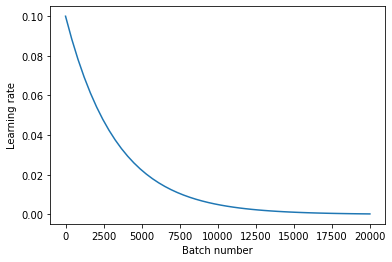

In [10]:
# Optimization hyperparameters
num_batchs = 20000        # Total number of batches to train on.
init_lr = 0.1          # initial learning rate
decay_factor = 0.9997     # decay the learning rate this much

learning_rate = optimizers.exponential_decay(init_lr, decay_steps=1, 
                                         decay_rate=decay_factor)

batch_idxs = np.linspace(1, num_batchs)
plt.plot(batch_idxs, [learning_rate(b) for b in batch_idxs])
plt.axis('tight')
plt.xlabel('Batch number')
plt.ylabel('Learning rate');

#### Train the Network

In [18]:
seed = 342343
print("Seed: %d" % seed)
prng_key = jax.random.PRNGKey(seed) # create a random key for jax for use on device.

########## Toy data parameters ##########
toy_params = {
  'phrase_length': 50,
  'loss_type': 'XE',
  'context_words' : False,
  'variable_length': False, # Takes max phrase length as phrase length
  'min_phrase_len': 10,
  'unordered_class': True, # Use an unordered class set
  'n_unordered': 2,
}

# toy_params['words'] = ['the', 'kinda1100', 'kinda0011', 'kinda1010', 'kinda0101']
toy_params['words'] = generateWordBank(toy_params)
# toy_params['sentiments'] = ['One', 'Two', 'Three', 'Four', 'Five']
# toy_params['words'].append('kinda01')
# toy_params['words'].append('kinda01')
# toy_params['words'].remove('kinda0')
# toy_params['words'].remove('kinda1')
# toy_params['words'].remove('very0')
# toy_params['words'].remove('very1')
# toy_params['words'].remove('very2')
# toy_params['words'].remove('very3')
# toy_params['words'].remove('very4')
# toy_params['words'].append('bad0')
# toy_params['words'].append('bad1')
# toy_params['sentiments'] = ['Red', 'Green', 'Blue']
toy_params['sentiments'] = ['Bad', 'Neutral', 'Good']
if toy_params['unordered_class']:
  toy_params['sentiments'] = ['sent'+str(i) for i in range(toy_params['n_unordered'])]

########## RNN hyperparameters ##########
rnn_specs = {
  'cell_type': 'GRU',                               # Supports 'GRU' or 'LSTM'
  'input_size': len(toy_params['words']),           # Number of inputs to the RNN
  'hidden_size': 128,                               # Number of units in the RNN
  'output_size': len(toy_params['sentiments']),     # Number of outputs in the RNN
  'ro_bias': False                                  # Include a bias with the readout
}

########## Train hyperparameters ##########

train_params = {
  'max_grad_norm': 10.0,      # max gradient norm before clipping, clip to this value.
  'l2reg': 0.00002,           # amount of L2 regularization on the weights

  'init_lr': 0.1,                     # initial learning rate
  'decay_factor': 0.9997,             # decay the learning rate this much
  'adam_b1': 0.9,                     # Adam parameters (b1=0.9, b2=0.99, eps=1e-8 are defaults)
  'adam_b2': 0.99,
  'adam_eps': 1e-1,

  'batch_size': 128,                     # How many examples in each batch
  'num_batchs': 1000,                    # Total number of batches to train on.
  'print_every': 100,                     # Print training informatino every so often

  'n_datasets': 2,                           # Number of new train sets to generate total (this is slow)
  'epochs': 1,                               # How many times to go through each train set completely
  'train_set_size': batch_size * num_batchs, # Number of examples in train set
  'test_set_size': 200,

  'decay_fun': optimizers.exponential_decay(init_lr, decay_steps=1, decay_rate=decay_factor),
}

########## Run ##########

print('Total words:', len(toy_params['words']), 'Words:', toy_params['words'])
print('Total sentiments:', len(toy_params['sentiments']), 'Sentiments:', toy_params['sentiments'])

new_network = True
load_network = False
save_data = False

path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/gru_2x2class_xe_noRO.pickle'
save_data = override_data(path, save_data)

if new_network:
  # Initialize the optimizer.  Please see jax/experimental/optimizers.py
  init_fun, apply_fun, mask_fun, loss_fun, accuracy_fun = build_rnn(rnn_specs)
  input_shape = (train_params['batch_size'], toy_params['phrase_length'], len(toy_params['words']))
  output_shape, initial_params = init_fun(prng_key, input_shape)

  opt = optimizers.adam(train_params['decay_fun'], train_params['adam_b1'], train_params['adam_b2'], train_params['adam_eps'])
  opt_state, step_fun = build_optimizer_step(opt, initial_params, loss_fun, gradient_clip=train_params['max_grad_norm'])
  
  init_opt, update_opt, get_params = opt

  train_params['train_losses'] = []
  train_params['global_step'] = 0
  train_params['total_steps'] = 0

elif load_network:
 
  initial_params = params_loaded_jax
  output_shape = (train_params['batch_size'], toy_params['phrase_length'], len(toy_params['sentiments']))

  opt = optimizers.adam(train_params['decay_fun'], train_params['adam_b1'], train_params['adam_b2'], train_params['adam_eps'])
  opt_state, step_fun = build_optimizer_step(opt, initial_params, loss_fun, gradient_clip=train_params['max_grad_norm'])

  init_opt, update_opt, get_params = opt

  train_params['train_losses'] = train_params['train_losses'] if 'train_losses' in train_params else []
  train_params['global_step'] = train_params['total_steps']

for dataset in range(train_params['n_datasets']):
  # Generate synthetic data and run training on said data
  opt_state, train_params = train_on_synthetic_data(opt_state, train_params, toy_params, rnn_specs)

save_run_data(path, save_data, get_params(opt_state), toy_params, rnn_specs, train_params)

# Destructure the trained parameters of the RNN.
final_params = get_params(opt_state)
rnn_params, readout_params = final_params

Seed: 342343
Total words: 5 Words: ['kinda0', 'very0', 'kinda1', 'very1', 'the']
Total sentiments: 2 Sentiments: ['sent0', 'sent1']
Sythentic data generated in: 39.52 sec.
Sythentic data generated in: 0.06 sec.
Running batches 0 to 1000
Step 100 in 4.49 sec, step size: 0.09707, test acc 0.5650, avg training loss 0.7116
Step 200 in 1.73 sec, step size: 0.09420, test acc 0.5800, avg training loss 0.6887
Step 300 in 1.74 sec, step size: 0.09142, test acc 0.6250, avg training loss 0.6319
Step 400 in 1.76 sec, step size: 0.08872, test acc 0.9850, avg training loss 0.4422
Step 500 in 1.73 sec, step size: 0.08610, test acc 0.9400, avg training loss 0.1670
Step 600 in 1.72 sec, step size: 0.08355, test acc 0.9350, avg training loss 0.1222
Step 700 in 1.74 sec, step size: 0.08108, test acc 0.9400, avg training loss 0.1025
Step 800 in 1.75 sec, step size: 0.07868, test acc 0.9850, avg training loss 0.0924
Step 900 in 1.77 sec, step size: 0.07636, test acc 0.9150, avg training loss 0.1133
Step 10

In [ ]:
# Save the network
train_params = {'total_steps': total_steps, 'decay_factor': decay_factor, 'init_step_size': step_size, 
                  'batch_size': batch_size, 'max_grad_norm': max_grad_norm, 'l2reg': l2reg}

path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data/lstm_3class_xe_noRO.pickle'

save_data = override_data(path, True)
save_run_data(path, save_data, get_params(opt_state), toy_params, rnn_specs, train_params)

File already exists. Override? (Y/N):Y
Data Saved


In [ ]:
# Loads network
path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data/gru_3class_xe_noRO.pickle'

with open(path, 'rb') as load_file:
    params_loaded = pickle.load(load_file)
    toy_params = pickle.load(load_file)
    rnn_specs = pickle.load(load_file)
    train_params = pickle.load(load_file)

rnn_params, readout_params = params_loaded

print('Data Loaded')

Data Loaded


Text(0, 0.5, 'Train Loss')

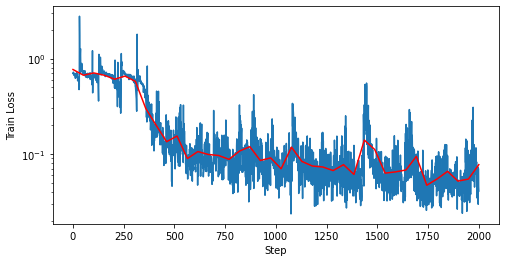

In [20]:
train_losses = train_params['train_losses']

plt.figure(figsize=(8, 4))
n_avg = 50
avg_loss = [1/n_avg * np.sum(train_losses[i*n_avg:(i+1)*n_avg]) for i in range(int(len(train_losses)/n_avg))]


plt.semilogy(np.linspace(1,len(train_losses),len(train_losses)), train_losses)
plt.semilogy(np.linspace(1,len(train_losses),int(len(train_losses)/n_avg)), avg_loss,'r')
plt.xlabel('Step')
plt.ylabel('Train Loss')

# Network Analysis

### Hidden State Analysis

In [ ]:
rnn_specs['cell_type'] = 'GRU'

In [380]:
# Here, we build some helper functions to collect RNN hidden states.
if rnn_specs['cell_type'] == 'GRU':
  print('Using GRU cell')
  cell = renn.GRU(rnn_specs['hidden_size'])
elif rnn_specs['cell_type'] == 'LSTM':
  print('Using LSTM cell')
  cell = renn.LSTM(rnn_specs['hidden_size'])

@jax.jit
def _get_all_states(inputs):
  """Get RNN states in response to a batch of inputs (also returns masked states)."""
  initial_states = cell.get_initial_state(rnn_params, batch_size=inputs.shape[0])
  return renn.unroll_rnn(initial_states, inputs, functools.partial(cell.batch_apply, rnn_params))

def rnn_states(batch, only_final=False):
  """Return (masked) RNN states."""
  states = _get_all_states(batch['inputs'])
  if only_final: # returns only the final hidden state
    return [h[batch['index'][0]] for h in states]
  else:
    return [h[:batch['index'][0]+1] for h in states]

Using GRU cell


In [390]:
# Get RNN hidden states in response to a test batch.
n_trials = 2000

syn_data_test = generate_data(n_trials, toy_params, rnn_specs['output_size'])

hs = rnn_states(syn_data_test)
pts = np.vstack(hs)[::2] # Gets every other state to eliminate states that are too close
print(pts.shape)

if rnn_specs['ro_bias']:
  wO, bO = readout_params
else:
  wO = readout_params
readout = wO.T

Sythentic data generated in: 0.71 sec.
(50000, 128)


Top 5 components: 0.9558214 ( [0.480355   0.42510614 0.02079798 0.01838343 0.01117887] )
Category 0 states: 594
Category 1 states: 487
Category 2 states: 510
Category 3 states: 409
Readout vec proj via PCA: [[-4.219596   -3.9168494   3.938361    4.1691194 ]
 [-3.9529984   4.421733   -4.2602043   4.058127  ]
 [ 0.58500946 -0.00664318 -0.03617217 -0.6048199 ]
 [-0.11274971  0.05582099 -0.2630027  -0.10977785]
 [ 0.21090537 -0.21130635 -0.26934463 -0.20560563]]


(128,)

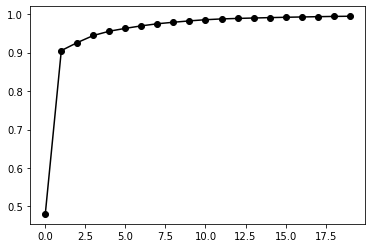

In [391]:
pc_dims = 5

# Finds percentage of variance explained by top pc_dims of PCA
pca_full = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_full.fit_transform(pts)
explained_var = pca_full.explained_variance_ratio_
print('Top', pc_dims, 'components:', np.sum(explained_var[:pc_dims]), '(', explained_var[:pc_dims],')')
total_exvar = []
for i in range(rnn_specs['hidden_size']-1):
  total_exvar.append(np.sum(explained_var[:i+1]))
plt.figure()
plt.plot(total_exvar[:20], 'k-o')

# Group these states by the corresponding label.
states = []
for i in range(len(toy_params['sentiments'])):
  states.append([h for h, lbl in zip(hs, syn_data_test['labels']) if np.argmax(lbl[toy_params['phrase_length']-1]) == i])
  print('Category {} states:'.format(i), len(states[i]))

# We use principal components analysis (PCA) for visualization.
pca = PCA(n_components=pc_dims).fit(pts)
comp = pca.components_ # pc_dims x n_hidden
print('Readout vec proj via PCA:', np.matmul(comp, readout.T))

# The initial state.
h0 = cell.get_initial_state(rnn_params)
h0.shape

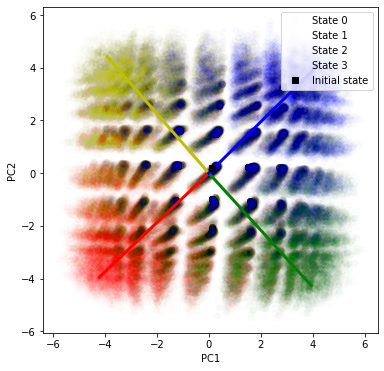

In [392]:
# Here, we visualize the hidden states of the RNN, projected into a
# low-dimensional 2D state space.

plt.figure(figsize=(6, 6))

pc1 = 0
pc2 = 1

# state_labels = ['Positive examples', 'Negative examples']
state_labels = ['State {}'.format(i) for i in range(len(toy_params['sentiments']))]
state_colors = ['r', 'y', 'g', 'b', 'm']
for i in range(len(toy_params['sentiments'])):
  pca_states = pca.transform(np.vstack(states[i])).T
  plt.plot(pca_states[pc1], pca_states[pc2], state_colors[i]+'o', alpha=0.01, label=state_labels[i])


# Plots readout direction
for i in range(len(readout)):
  ro_dir = np.matmul(comp, readout[i])
  x_ro = [0, ro_dir[pc1]]
  y_ro = [0, ro_dir[pc2]]
  plt.plot(x_ro, y_ro, state_colors[i], linewidth = 3)

pca_h0 = pca.transform(np.atleast_2d(h0)).T
plt.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')

plt.xlabel('PC'+str(pc1+1))
plt.ylabel('PC'+str(pc2+1))
# plt.xlim(-5, 5)
# plt.ylim(-5, 5)

plt.legend()

#### Readout Vector Analysis

In [384]:
# Percentage of readout vector mag in PCA dimensions

if rnn_specs['ro_bias']:
  wO, bO = readout_params
else:
  wO = readout_params
readout = wO.T

readout_mags = []
readout_pca_mags = []
pc_dims = 4
for i in range(len(readout)):
  readout_mags.append(np.linalg.norm(readout[i]))
  readout_pca_mags.append(np.linalg.norm(np.matmul(comp, readout.T).T[i][:pc_dims]))
  print('Readout {} mag:'.format(i), readout_mags[i])
  print('Readout {}'.format(i), '(perc in first {} PC dims):'.format(pc_dims), readout_pca_mags[i]/readout_mags[i])

Readout 0 mag: 6.197044
Readout 0 (perc in first 4 PC dims): 0.93833846
Readout 1 mag: 6.423263
Readout 1 (perc in first 4 PC dims): 0.91968876
Readout 2 mag: 6.2768364
Readout 2 (perc in first 4 PC dims): 0.92575854
Readout 3 mag: 6.3114104
Readout 3 (perc in first 4 PC dims): 0.9279958


In [385]:
def subspace_perc(A, b):
  """
  A: an N x M matrix, whose column space represents some M-dimensional subspace
  b: an N x 1 vector
  Finds the percentage of b's magnitude which lies in the subspace formed by the columns of A (its columnspace)
  """
  proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T)
  b_proj = np.matmul(proj, b)

  return np.linalg.norm(b_proj)/np.linalg.norm(b)

read_out_mags = []
for i in range(len(readout)):
  read_out_mags.append(np.linalg.norm(readout[i]))

print('Theoretical angle:', 180/np.pi * np.arccos(-1/toy_params['n_unordered']))

for i in range(len(readout)):
  for j in range(i):
    print('Angle ({}, {}):'.format(i,j), 180/np.pi * np.arccos(np.dot(readout[i], readout[j])/(read_out_mags[i]*read_out_mags[j])))

indices = [i for i in range(len(readout))]
for i in range(len(readout)):
  A = []
  for j in range(len(readout)):
    if i != j:
      A.append(readout[j])
  print('Perc of {} in rest:'.format(i), subspace_perc(np.asarray(A).T, readout[i]))

Theoretical angle: 104.47751218592994
Angle (1, 0): 94.08999491156267
Angle (2, 0): 87.24735430669298
Angle (2, 1): 161.97564122329126
Angle (3, 0): 161.22076871622144
Angle (3, 1): 85.61897573685941
Angle (3, 2): 93.49279049129343
Perc of 0 in rest: 0.94718504
Perc of 1 in rest: 0.9514437
Perc of 2 in rest: 0.951382
Perc of 3 in rest: 0.94708014


In [ ]:
# Exact symplex numbers

simplex = []
simplex.append(np.asarray([1,0,0]))
simplex.append(np.asarray([-1/3, np.sqrt(8)/3, 0]))
simplex.append(np.asarray([-1/3, -np.sqrt(2)/3, np.sqrt(2/3)]))
simplex.append(np.asarray([-1/3, -np.sqrt(2)/3, -np.sqrt(2/3)]))

read_out_mags = []
for i in range(len(simplex)):
  read_out_mags.append(np.linalg.norm(simplex[i]))

print(read_out_mags)

for i in range(len(simplex)):
  for j in range(i):
    print('Angle ({}, {}):'.format(i,j), 180/np.pi * np.arccos(np.dot(simplex[i], simplex[j])/(read_out_mags[i]*read_out_mags[j])))

A01 = np.array([simplex[0], simplex[1]]).T
A02 = np.array([simplex[0], simplex[2]]).T
A12 = np.array([simplex[1], simplex[2]]).T

print('Perc of 2 in (0,1):', subspace_perc(A01, simplex[2]))
print('Perc of 1 in (0,2):', subspace_perc(A02, simplex[1]))
print('Perc of 0 in (1,2):', subspace_perc(A12, simplex[0]))

[1.0, 1.0, 1.0, 1.0]
Angle (1, 0): 109.47122063449069
Angle (2, 0): 109.47122063449069
Angle (2, 1): 109.47122063449069
Angle (3, 0): 109.47122063449069
Angle (3, 1): 109.47122063449069
Angle (3, 2): 109.47122063449069
Perc of 2 in (0,1): 0.5773502691896258
Perc of 1 in (0,2): 0.5773502691896258
Perc of 0 in (1,2): 0.5773502691896257


In [ ]:
np.dot(np.matmul(np.vstack(states[i]), proj), x_basis).shape

(15800,)

### Find Fixed Points

In [395]:
fp_loss_fun = renn.build_fixed_point_loss(cell, rnn_params)

fixed_points, loss_hist, fp_losses = renn.find_fixed_points(fp_loss_fun, pts,
                                                            jnp.zeros((pts.shape[0], rnn_specs['input_size'])),
                                                            optimizers.adam(0.01),
                                                            tolerance=1e-3)
print('Done')


















  0%|          | 0/10000 [00:00<?, ?it/s]
















  0%|          | 1/10000 [00:00<40:34,  4.11it/s]
















  0%|          | 23/10000 [00:00<28:34,  5.82it/s]
















  0%|          | 44/10000 [00:00<20:11,  8.21it/s]
















  1%|          | 66/10000 [00:00<14:20, 11.55it/s]
















  1%|          | 88/10000 [00:00<10:14, 16.13it/s]
















  1%|          | 111/10000 [00:00<07:22, 22.35it/s]
















  1%|▏         | 134/10000 [00:00<05:22, 30.62it/s]
















  2%|▏         | 157/10000 [00:00<03:58, 41.32it/s]
















  2%|▏         | 180/10000 [00:01<02:59, 54.76it/s]
















  2%|▏         | 202/10000 [00:01<02:18, 70.50it/s]
















  2%|▏         | 225/10000 [00:01<01:50, 88.61it/s]
















  2%|▏         | 248/10000 [00:01<01:30, 108.26it/s]
















  3%|▎         | 272/10000 [00:01<01:15, 129.26it/s]
















  3%|▎         | 296/10000 [00:01<01:05, 148.

Done


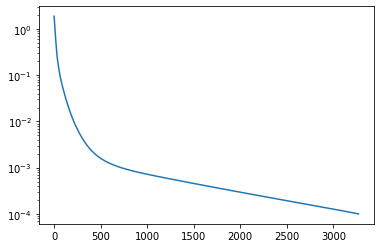

In [ ]:
plt.semilogy(loss_hist)

Text(0, 0.5, 'PC2')

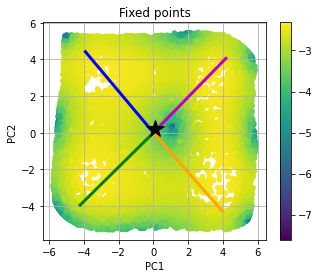

In [396]:
# 2D Visualization of the approximate fixed points: the line attractor.

pc1 = 0
pc2 = 1

plt.figure(figsize=(5, 4))
pca_fps = pca.transform(np.vstack(fixed_points)).T
plt.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c=np.log10(fp_losses))
# plt.xlim(-8, 8)
# plt.ylim(-8, 8)
plt.grid()

plt.colorbar()

# pca_word = 1*word_deflection('kinda0', cell, toy_params, rnn_params, rnn_specs, fixed_points[fp_idx], comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='k')
# pca_word = 1*word_deflection('kinda1', cell, toy_params, rnn_params, rnn_specs, fixed_points[fp_idx], comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='r')
# pca_word = 3*word_deflection('kinda01', cell, toy_params, rnn_params, rnn_specs, h0, comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='b')

# Plots readout direction
ro_colors = ['g', 'b', 'orange', 'm', 'r']
for i in range(len(readout)):
  ro_dir = np.matmul(comp, readout[i])
  x_ro = [0, ro_dir[pc1]]
  y_ro = [0, ro_dir[pc2]]
  plt.plot(x_ro, y_ro, ro_colors[i], linewidth = 3)

pca_h0 = pca.transform(np.atleast_2d(h0)).T
plt.plot(pca_h0[pc1], pca_h0[pc2], '*', color='k', ms=18)
plt.title('Fixed points')

plt.xlabel('PC'+str(pc1+1))
plt.ylabel('PC'+str(pc2+1))

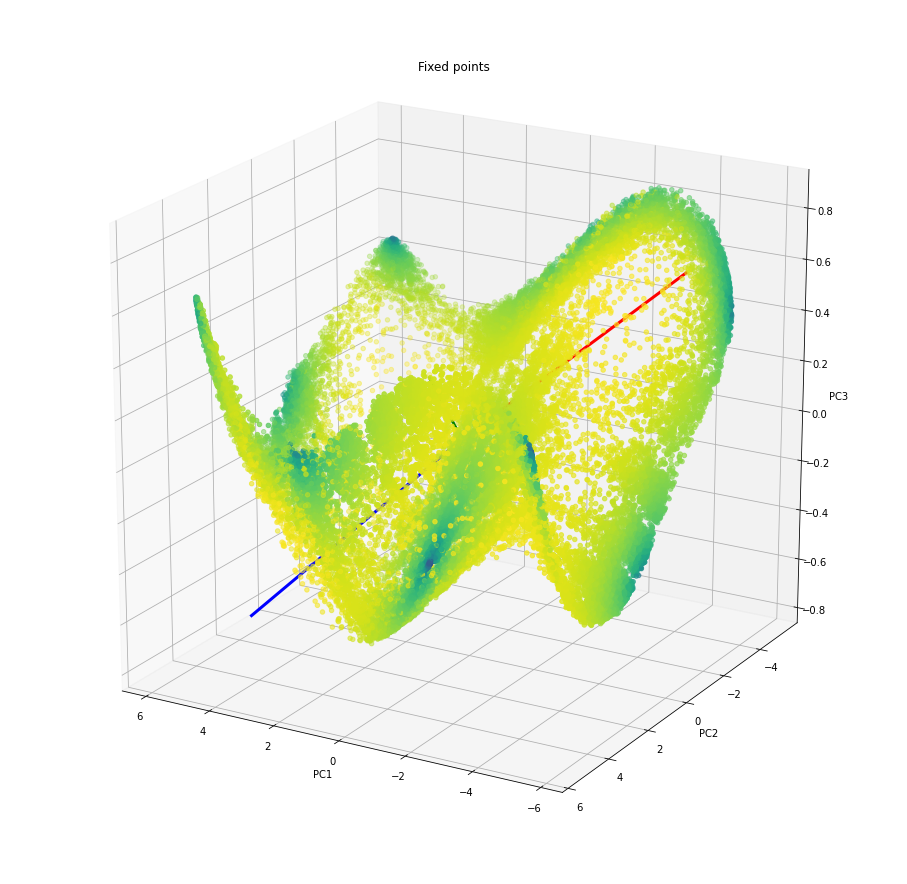

In [397]:
# triangulate in the underlying parametrization
from matplotlib.tri import Triangulation

pc1 = 0
pc2 = 1
pc3 = 2

fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111, projection='3d');


pca_fps = pca.transform(np.vstack(fixed_points)).T
# max_loss = np.max(np.log10(fp_losses))
# min_loss = np.min(np.log10(fp_losses))
# loss_range = max_loss - min_loss
# colors = []
# for loss in fp_losses:
#   seq_color_norm = (np.log10(loss)-min_loss)/loss_range
#   colors.append((seq_color_norm, 0, 1 - seq_color_norm, 1.0))
# ax.plot_trisurf(pca_fps[pc1], pca_fps[pc2], pca_fps[pc3], edgecolor='none', color='grey')
ax.scatter(pca_fps[pc1], pca_fps[pc2], pca_fps[pc3], s=20, c=np.log10(fp_losses))

# Plots readout direction
ro_colors = ['r', 'y', 'g', 'b', 'm']
for i in range(len(readout)):
  ro_dir = np.matmul(comp, readout[i])
  x_ro = [pca_h0[pc1], ro_dir[pc1]]
  y_ro = [pca_h0[pc2], ro_dir[pc2]]
  z_ro = [pca_h0[pc3], ro_dir[pc3]]
  plt.plot(x_ro, y_ro, z_ro, ro_colors[i], linewidth = 3)

pca_h0 = pca.transform(np.atleast_2d(h0)).T
plt.plot(pca_h0[pc1], pca_h0[pc2], pca_h0[pc3], '*', color='lightcoral', ms=18)
plt.title('Fixed points')

# pca_word = 3*word_deflection('very1', cell, toy_params, rnn_params, rnn_specs, h0, comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='k')
# pca_word = 3*word_deflection('very0', cell, toy_params, rnn_params, rnn_specs, h0, comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='r')
# pca_word = 3*word_deflection('kinda01', cell, toy_params, rnn_params, rnn_specs, h0, comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='b')

ax.set_xlabel('PC'+str(pc1+1))
ax.set_ylabel('PC'+str(pc2+1))
ax.set_zlabel('PC'+str(pc3+1))

# Azimuthal angle and rotation
ax.view_init(20, 120)

#### Single Fixed Point Analysis

Text(0, 0.5, 'PC2')

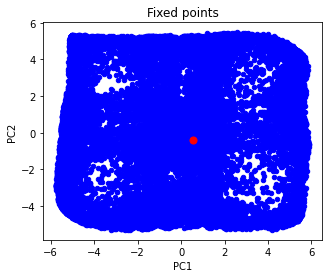

In [398]:
# Pick a fixed point.
# fp_idx = np.argmin(fp_losses)
fp_idx = 350
fp = fixed_points[fp_idx]

# 2D Visualization of where said fixed point is
pc1 = 0
pc2 = 1

plt.figure(figsize=(5, 4))
pca_fps = pca.transform(np.vstack(fixed_points)).T
plt.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c='b')
plt.scatter(pca_fps[pc1][fp_idx], pca_fps[pc2][fp_idx], s=50, c='r')

plt.title('Fixed points')

plt.xlabel('PC'+str(pc1+1))
plt.ylabel('PC'+str(pc2+1))

In [400]:
# Computes the recurrent Jacobian.
jac = jax.device_get(cell.rec_jac(rnn_params, jnp.zeros(rnn_specs['input_size']), fp))

# Perform an eigendecomposition to get eigenvectors and eigenvalues.
R, E, L = renn.eigsorted(jac)

Text(0, 0.5, 'imag')

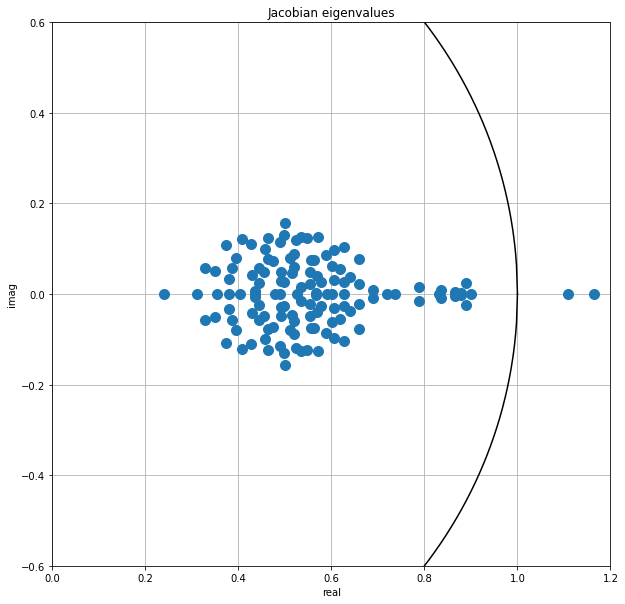

In [401]:
plt.figure(figsize=(10,10))
plt.plot(np.real(E), np.imag(E), 'o', ms=10)
plt.grid()
plt.xlim(0, 1.2)
plt.ylim(-0.6, 0.6)
# Makes unit circle
x = np.linspace(-1, 1, 1000)
plt.plot(x, np.sqrt(1-x**2), 'k')
plt.plot(x, -np.sqrt(1-x**2), 'k')

plt.title('Jacobian eigenvalues')
plt.xlabel('real')
plt.ylabel('imag')

#### Many Fixed Point Analysis

In [369]:
# Jacobian projections
def word_deflection(word, cell, toy_params, rnn_params, rnn_specs, hs, comp):
  """ Returns (linearized) deflection of word from hs in terms of pcs of comp""" 
  word_tensor = wordToTensor(word, toy_params['words'])
  input_jac = cell.inp_jac(rnn_params, jnp.zeros(rnn_specs['input_size']), hs)
  hidden_update = np.matmul(input_jac, word_tensor[0])
  
  return np.matmul(comp, hidden_update)

def hs_modes(n_eigs, cell, toy_params, rnn_params, rnn_specs, hs, comp):
  """ Returns deflection of top n_eigs eigenvalues from hs in terms of pcs of comp""" 
  jac = jax.device_get(cell.rec_jac(rnn_params, jnp.zeros(rnn_specs['input_size']), hs))
  R, E, L = renn.eigsorted(jac)

  print('HS top eigenvalues:', E[:n_eigs+1])

  return np.matmul(comp, R[:, :n_eigs]).T

In [370]:
# Plots Jacobian eigenvalues as a function of fixed point

pca_fps = pca.transform(np.vstack(fixed_points)).T

# Sorts fixed points by pc dimension
# sort_idxs = np.argsort(pca_fps[0])
# sorted_pca_fps = pca_fps[0][sort_idxs]
# sorted_fp = fixed_points[sort_idxs]

# Sorts fixed points by distance from mean fixed point
fp_mean = np.mean(fixed_points, axis=0)
fp_dist = np.zeros((fixed_points.shape[0],))
for fp_idx in range(fixed_points.shape[0]):
  fp_dist[fp_idx] = np.linalg.norm(fixed_points[fp_idx]-fp_mean, ord=1)
sort_idxs = np.argsort(fp_dist)
sorted_fpidx = fp_dist[sort_idxs]
sorted_fp = fixed_points[sort_idxs]


take_every = 25
n_top = 8
n_fp = len(fixed_points)
print('Evaluating {} fixed points.'.format(n_fp))
max_evals = np.zeros((int(n_fp/take_every), n_top))
max_evals_im = np.zeros((int(n_fp/take_every), n_top))
pc_dim_val = np.zeros(int(n_fp/take_every))

for i in tqdm(range(0, int(n_fp/take_every))):
  fp = sorted_fp[i*take_every]
  jac = jax.device_get(cell.rec_jac(rnn_params, jnp.zeros(rnn_specs['input_size']), fp))
  _, E, _ = renn.eigsorted(jac)
  rE = np.real(E)
  iE = np.imag(E)
  rE.sort()
  iE.sort()
  pc_dim_val[i] = sorted_fpidx[i*take_every]
  max_evals[i] = rE[-n_top:]
  max_evals_im[i] = iE[-n_top:]

Evaluating 25000 fixed points.


Text(0, 0.5, 'Top Im(Eigenvalues)')

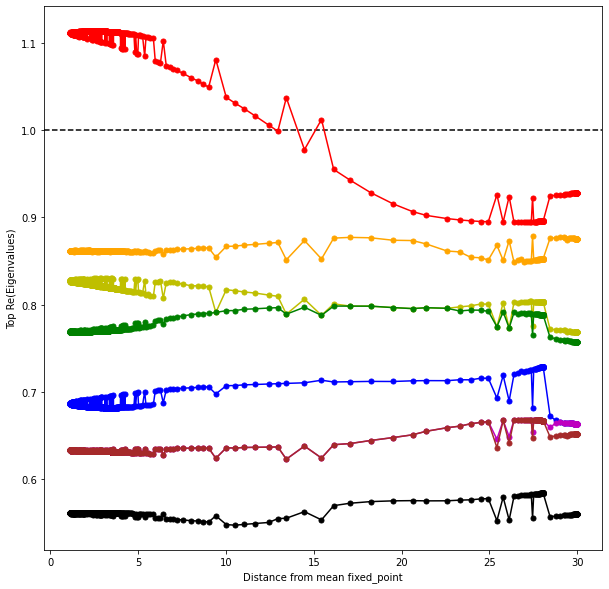

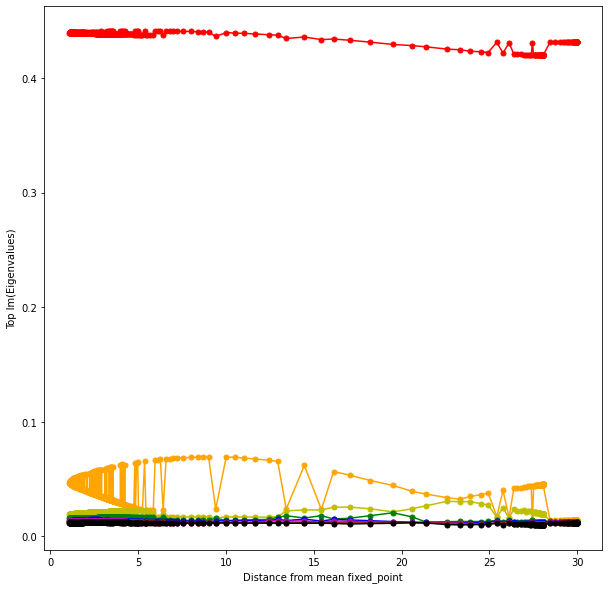

In [371]:
plt.figure(figsize=(10,10))
plt.axhline(1.0, c='k', linestyle='--')
colors = ['r', 'orange', 'y', 'g', 'b', 'm', 'brown', 'k']
for i in range(n_top):
  plt.plot(pc_dim_val, max_evals[:,n_top-1-i], '.-', ms=10, c=colors[i])

plt.xlabel('PC1')
plt.xlabel('Distance from mean fixed_point')
plt.ylabel('Top Re(Eigenvalues)')

plt.figure(figsize=(10,10))
colors = ['r', 'orange', 'y', 'g', 'b', 'm', 'brown', 'k']
for i in range(n_top):
  plt.plot(pc_dim_val, max_evals_im[:,n_top-1-i], '.-', ms=10, c=colors[i])

plt.xlabel('PC1')
plt.xlabel('Distance from mean fixed_point')
plt.ylabel('Top Im(Eigenvalues)')

In [ ]:
print('Number of fixed points:', len(fixed_points))

Number of fixed points: 25000


HS top eigenvalues: [0.8956536+0.j 0.8526117+0.j 0.8031965+0.j]
HS top eigenvalues: [0.89565367+0.j 0.8526116 +0.j 0.8031965 +0.j]
HS top eigenvalues: [1.1041673 +0.j 0.86134094+0.j 0.8294861 +0.j]
HS top eigenvalues: [1.1124028 +0.j 0.8614164 +0.j 0.81864643+0.j]
HS top eigenvalues: [1.0988455 +0.j 0.85771126+0.j 0.8039921 +0.j]


Text(0, 0.5, 'PC2')

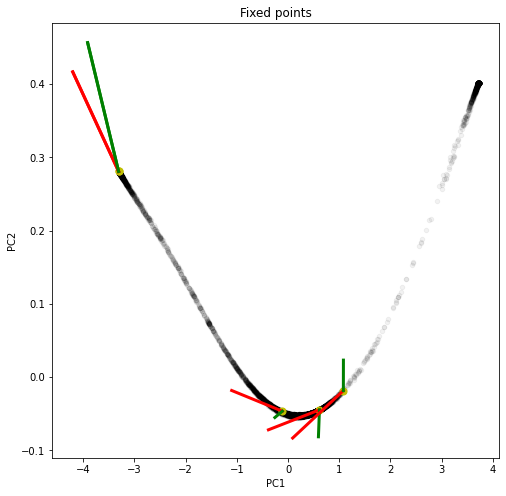

In [372]:
# Zero modes
fp_idxs =[600, 1000, 4000, 22000, 24000]
num_eigs = 2
scale = 1 # Amount to scale up eigenvalues

# 2D Visualization of where said fixed point is
pc1 = 0
pc2 = 1
plt.figure(figsize=(8, 8))

# Sorts fixed points by pc1 dimension
pca_fps = pca.transform(np.vstack(fixed_points)).T
sort_idxs = np.argsort(pca_fps[pc1])
sorted_fp = fixed_points[sort_idxs]

pca_fps = pca.transform(np.vstack(sorted_fp)).T
plt.scatter(pca_fps[pc1], pca_fps[pc2], alpha=0.05, s=20, c='k')

eig_colors = ['r', 'g', 'm', 'b', 'orange', 'grey']
for fp_idx in fp_idxs:
  mode_proj = scale * np.real(hs_modes(num_eigs, cell, toy_params, rnn_params, rnn_specs, sorted_fp[fp_idx], comp))
  for i in range(num_eigs):
    plt.plot(pca_fps[pc1][fp_idx] + [0, mode_proj[i][pc1]], pca_fps[pc2][fp_idx] + [0, mode_proj[i][pc2]], eig_colors[i], linewidth=3)
  plt.scatter(pca_fps[pc1][fp_idx], pca_fps[pc2][fp_idx], s=50, c='y')

plt.title('Fixed points')

plt.xlabel('PC'+str(pc1+1))
plt.ylabel('PC'+str(pc2+1))

In [360]:
word_tensor = wordToTensor('not', toy_params['words'])

# Finds deflection of RNNs for a given input
ref_idx = 400
ref_fp = fixed_points[ref_idx]
def_state = cell.apply(rnn_params, word_tensor[0], ref_fp)
delta_hnot_ref = def_state - ref_fp
delta_hnot_ref_mag = np.linalg.norm(delta_hnot_ref)

# Sorts fixed points by pc1 dimension
pca_fps = pca.transform(np.vstack(fixed_points)).T
sort_idxs = np.argsort(pca_fps[0])
sorted_pca_fps = pca_fps[0][sort_idxs]
sorted_fp = fixed_points[sort_idxs]

take_every = 10
n_fp = len(fixed_points)
n_eval = int(n_fp/take_every)

def_state = np.zeros((n_eval, rnn_specs['hidden_size']))
delta_hnot = np.zeros((n_eval, rnn_specs['hidden_size']))
hnot_angles = np.zeros((n_eval,))
hnot_mags = np.zeros((n_eval,))
pc_dim_val = np.zeros((n_eval,))
for i in tqdm(range(0, n_eval)):
  def_state[i] = cell.apply(rnn_params, word_tensor[0], sorted_fp[i*take_every])
  delta_hnot[i] = def_state[i] - sorted_fp[i*take_every]
  pc_dim_val[i] = sorted_pca_fps[i*take_every]
  hnot_mags[i] = np.linalg.norm(delta_hnot[i])
  hnot_angles[i] = 180/np.pi * np.arccos(np.dot(delta_hnot[i], delta_hnot_ref)/(hnot_mags[i]*delta_hnot_ref_mag))

delta_hnot_mean = np.mean(delta_hnot)
hnot_perc_diff = np.zeros((n_eval,))
for i in range(0, n_eval):
  mean_diff = delta_hnot[i] - delta_hnot_mean
  hnot_perc_diff[i] = np.linalg.norm(mean_diff)/hnot_mags[i]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in arccos


Text(0, 0.5, 'Perc diff from mean')

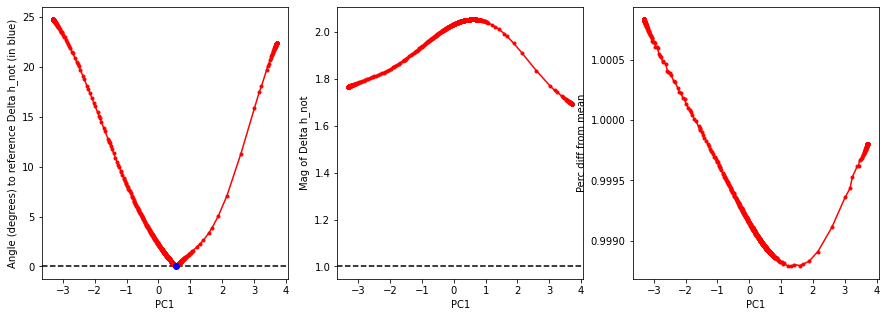

In [361]:
plt.figure(figsize=(15,5))
ax1 = plt.subplot('131')
ax1.axhline(0.0, c='k', linestyle='--')
ax1.plot(pc_dim_val, hnot_angles, 'r-', marker='.')
ax1.plot(pca_fps[0][ref_idx], [0.0], 'b-o')

ax1.set_xlabel('PC1')
ax1.set_ylabel('Angle (degrees) to reference Delta h_not (in blue)')

ax2 = plt.subplot('132')
ax2.axhline(1.0, c='k', linestyle='--')
ax2.plot(pc_dim_val, hnot_mags, 'r-', marker='.')

ax2.set_xlabel('PC1')
ax2.set_ylabel('Mag of Delta h_not')

ax3 = plt.subplot('133')
ax3.plot(pc_dim_val, hnot_perc_diff, 'r-', marker='.')

ax3.set_xlabel('PC1')
ax3.set_ylabel('Perc diff from mean')

Text(0, 0.5, 'PC2')

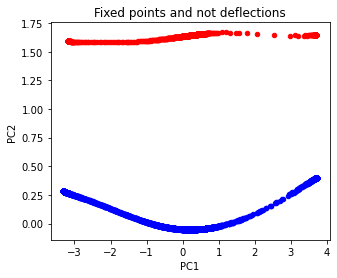

In [362]:
# Plots fixed points and deflected states

# 2D Visualization of where said fixed point is
pc1 = 0
pc2 = 1

plt.figure(figsize=(5, 4))
pca_fps = pca.transform(np.vstack(fixed_points)).T
plt.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c='b')

pca_defs = pca.transform(np.vstack(def_state)).T
plt.scatter(pca_defs[pc1], pca_defs[pc2], s=20, c='r')

plt.title('Fixed points and not deflections')

plt.xlabel('PC'+str(pc1+1))
plt.ylabel('PC'+str(pc2+1))

#### Readout Space Projection

x 0.99999994
y 0.99999994
x.y -4.4703484e-08


(-7.0, 7.0)

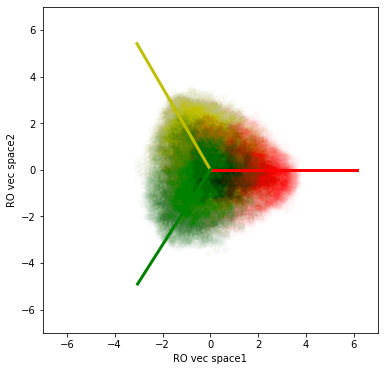

In [ ]:
# Project hidden states onto the readout space
ro1 = 0
ro2 = 1

# Creates basis vectors for the readout space
x_basis = readout[ro1] / np.linalg.norm(readout[ro1])
y_vec = readout[ro2] - np.dot(x_basis, readout[ro2]) * x_basis
y_basis = y_vec / np.linalg.norm(y_vec)
print('x', np.linalg.norm(x_basis))
print('y', np.linalg.norm(y_basis))
print('x.y', np.dot(x_basis, y_basis))

A = np.array([x_basis, y_basis]).T
proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T) # 2 x n_hidden
plt.figure(figsize=(6, 6))

# state_labels = ['Positive examples', 'Negative examples']
state_labels = ['State {}'.format(i) for i in range(len(toy_params['sentiments']))]
state_colors = ['r', 'y', 'g', 'b', 'm']
for i in range(len(toy_params['sentiments'])):
  x_vals = np.dot(np.matmul(np.vstack(states[i]), proj), x_basis)
  y_vals = np.dot(np.matmul(np.vstack(states[i]), proj), y_basis)
  plt.plot(x_vals, y_vals, state_colors[i]+'o', alpha=0.01, label=state_labels[i])

ro_colors = ['r', 'y', 'g', 'b', 'm']
for i in range(len(readout)):
  ro_proj = np.matmul(proj, readout[i])
  plt.plot([0, np.dot(x_basis, ro_proj)], [0, np.dot(y_basis, ro_proj)], ro_colors[i], linewidth = 3)

plt.xlabel('RO vec space1')
plt.ylabel('RO vec space2')

plt.xlim(-7, 7)
plt.ylim(-7, 7)

x 0.99999994
y 0.99999994
x.y -4.4703484e-08


(-7.0, 7.0)

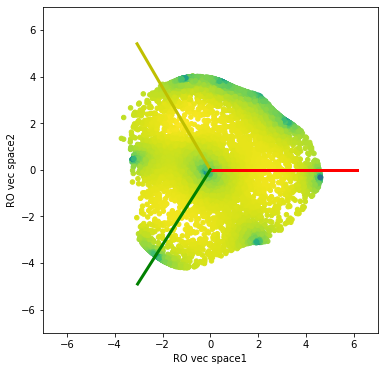

In [ ]:
# Project fixed points onto the readout space
ro1 = 0
ro2 = 1

# Creates basis vectors for the readout space
x_basis = readout[ro1] / np.linalg.norm(readout[ro1])
y_vec = readout[ro2] - np.dot(x_basis, readout[ro2]) * x_basis
y_basis = y_vec / np.linalg.norm(y_vec)
print('x', np.linalg.norm(x_basis))
print('y', np.linalg.norm(y_basis))
print('x.y', np.dot(x_basis, y_basis))

A = np.array([x_basis, y_basis]).T
proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T) # 2 x n_hidden
plt.figure(figsize=(6, 6))

# Fixed points
x_vals = np.dot(np.matmul(np.vstack(fixed_points), proj), x_basis)
y_vals = np.dot(np.matmul(np.vstack(fixed_points), proj), y_basis)
plt.scatter(x_vals, y_vals, s=20, c=np.log10(fp_losses))
plt.colorbar

ro_colors = ['r', 'y', 'g', 'b', 'm']
for i in range(len(readout)):
  ro_proj = np.matmul(proj, readout[i])
  plt.plot([0, np.dot(x_basis, ro_proj)], [0, np.dot(y_basis, ro_proj)], ro_colors[i], linewidth = 3)

plt.xlabel('RO vec space1')
plt.ylabel('RO vec space2')

plt.xlim(-7, 7)
plt.ylim(-7, 7)

# Training Analysis

In [ ]:
def 